In [15]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

| Architecture | Simple1d | Simple1dEmbedding | Simple2d | Simple2dEmbedding | ResNet50 | ResNet50Embedding |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| alpha | 0.996±0.003 | 0.954±0.051 | 1.000±0.000 | 0.949±0.056 | 0.987±0.008 | 0.974±0.046 |
| amd64 | 0.979±0.016 | 0.995±0.010 | 0.944±0.015 | 0.998±0.004 | 0.950±0.005 | 0.995±0.005 |
| arm64 | 0.777±0.251 | 0.791±0.207 | 0.365±0.134 | 0.581±0.287 | 0.200±0.098 | 0.547±0.309 |
| armel | 1.000±0.000 | 0.992±0.009 | 1.000±0.000 | 0.985±0.019 | 1.000±0.000 | 0.985±0.017 |
| armhf | 0.946±0.023 | 0.985±0.015 | 0.981±0.013 | 0.978±0.020 | 0.972±0.007 | 0.976±0.018 |
| hppa | 0.491±0.312 | 0.717±0.261 | 0.121±0.042 | 0.729±0.146 | 0.441±0.129 | 0.591±0.207 |
| i386 | 0.970±0.021 | 0.998±0.003 | 0.978±0.023 | 0.997±0.005 | 0.964±0.016 | 0.977±0.016 |
| ia64 | 0.604±0.488 | 0.792±0.283 | 0.060±0.070 | 0.662±0.423 | 0.715±0.259 | 0.494±0.327 |
| m68k | 0.174±0.315 | 0.094

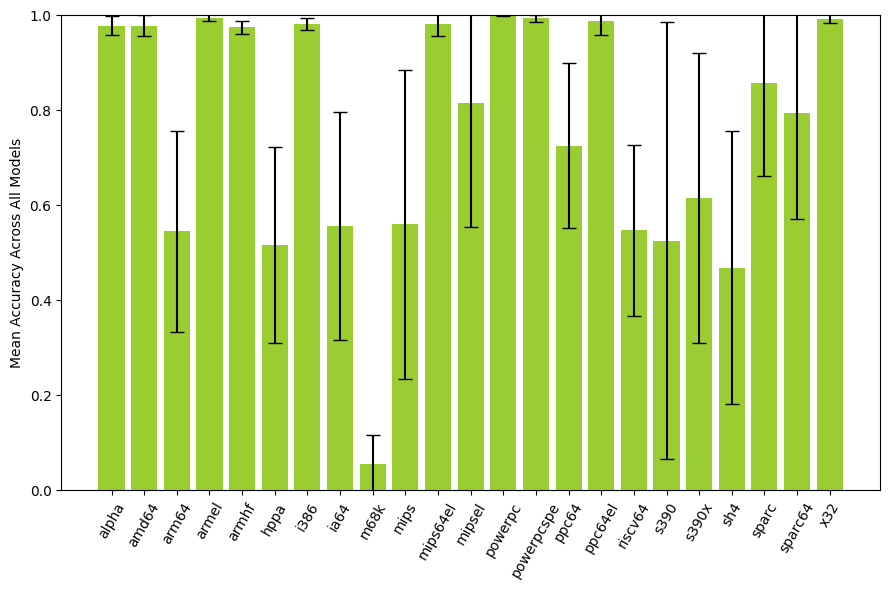

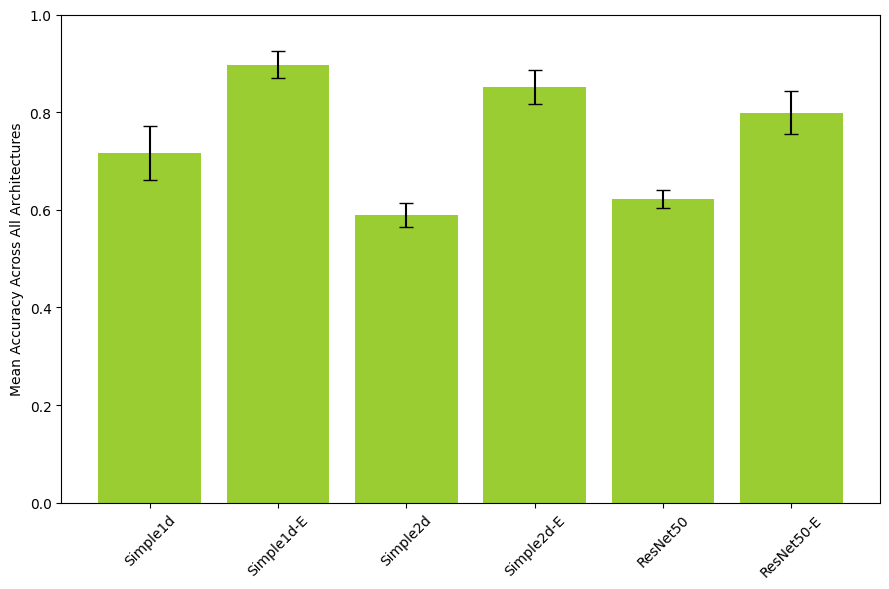

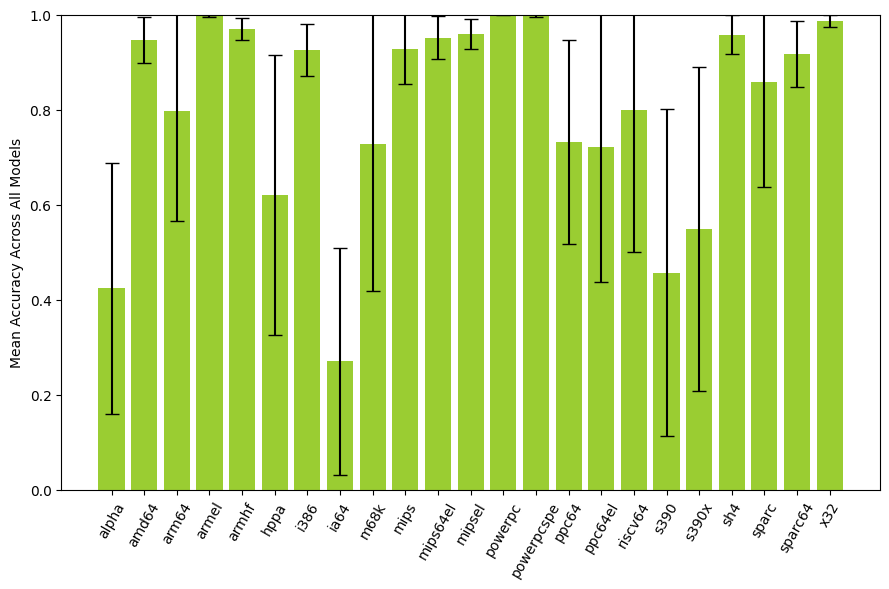

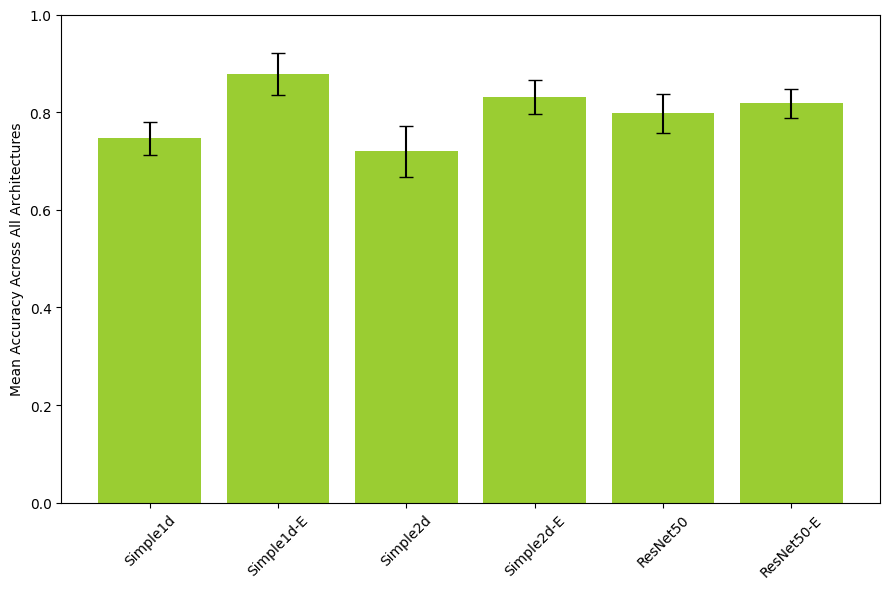

In [16]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    # Create a dictionary to store results for each model
    model_results = {}
    model_overall_results = {}

    # Get all unique architectures across all models
    all_architectures = set()

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Get overall metrics
        df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
        overall_mean = df_overall["overall_accuracy"].mean()
        overall_std = df_overall["overall_accuracy"].std()
        model_overall_results[model_name] = (overall_mean, overall_std)

        # Get per-architecture metrics
        df_filtered = df[["Name", "test_accuracy_file", "test_loss", "train_loss"]]
        df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
            columns={"Name": "architecture"}
        )
        df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

        df_agg = (
            df_folds.groupby("architecture")
            .agg({"test_accuracy_file": ["mean", "std"]})
            .reset_index()
        )

        # Store results and collect architectures
        model_results[model_name] = {
            arch: (mean, std)
            for arch, mean, std in zip(
                df_agg["architecture"],
                df_agg[("test_accuracy_file", "mean")],
                df_agg[("test_accuracy_file", "std")],
            )
        }
        all_architectures.update(df_agg["architecture"])

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)
    table_string += "\n"

    # Sort architectures alphabetically
    sorted_architectures = sorted(all_architectures)

    # Add rows for each architecture
    for arch in sorted_architectures:
        table_string += f"| {arch} |"
        for model in model_names:
            if arch in model_results[model]:
                mean, std = model_results[model][arch]
                table_string += f" {mean:.3f}±{std:.3f} |"
            else:
                table_string += " - |"
        table_string += "\n"

    # Add overall row
    table_string += "| **Overall** |"
    for model in model_names:
        mean, std = model_overall_results[model]
        table_string += f" **{mean:.3f}±{std:.3f}** |"
    table_string += "\n"

    # Save the table
    filename = (
        f"output/logo-{target_feature.replace('_', '').lower()}-combined-results.md"
    )
    with open(filename, "w") as f:
        f.write(table_string)

    print(table_string)

    # Create bar chart aggregated by architecture
    plt.figure(figsize=(9, 6))
    arch_means = []
    arch_stds = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in model_results[model]:
                arch_values.append(model_results[model][arch][0])
        arch_means.append(np.mean(arch_values))
        arch_stds.append(np.std(arch_values))

    bars = plt.bar(
        range(len(sorted_architectures)),
        arch_means,
        yerr=arch_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(sorted_architectures)), sorted_architectures, rotation=60)
    plt.ylabel("Mean Accuracy Across All Models")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/logo-{target_feature.replace('_', '').lower()}-by-architecture.png"
    )

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_stds = []

    for model in model_names:
        mean, std = model_overall_results[model]
        model_means.append(mean)
        model_stds.append(std)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All Architectures")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/logo-{target_feature.replace('_', '').lower()}-by-model.png")